### Hyperparameters:
| Hyperparameter       | Value   |
|----------------------|---------|
| num-filters          | 32      |
| num-bilstm-layer     | 2       |
| output-lstm-dim      | 64      |
| decay-rate           | 0.8     |
| learning-rate        | 0.01    |
| miniBatchSize        | 256     |
| filter-size          | 10 × 1  |
| input-lstm-dim       | 100     |
| L2Regularization     | 0.001   |
| optimizer            | Adam    |
| dropout              | 0.25    |
| maxEpochs            | 500     |

In [1]:
import sys
sys.path.append("..")

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

## CNN-BiLSTM

In [41]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [42]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [43]:
model = CNNBiLSTM(input_dim=len(features))

In [44]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [45]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [46]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 192261
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.69it/s]


Epoch [1/500] - Train Loss: 1.323016, Val Loss: 20.539040
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 147.82it/s]


Epoch [2/500] - Train Loss: 1.123911, Val Loss: 18.307424
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.92it/s]


Epoch [3/500] - Train Loss: 0.865916, Val Loss: 14.784926
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 41.92it/s]


Epoch [4/500] - Train Loss: 0.611825, Val Loss: 9.805793
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.31it/s]


Epoch [5/500] - Train Loss: 0.458382, Val Loss: 5.714993
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.85it/s]


Epoch [6/500] - Train Loss: 0.243238, Val Loss: 3.744014
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.31it/s]


Epoch [7/500] - Train Loss: 0.119611, Val Loss: 1.280820
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.63it/s]


Epoch [8/500] - Train Loss: 0.059886, Val Loss: 0.477493
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.17it/s]


Epoch [9/500] - Train Loss: 0.037386, Val Loss: 0.466189
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.86it/s]


Epoch [10/500] - Train Loss: 0.165113, Val Loss: 0.846241
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.83it/s]


Epoch [11/500] - Train Loss: 0.154422, Val Loss: 0.654430
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.20it/s]


Epoch [12/500] - Train Loss: 0.165771, Val Loss: 1.381848
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.21it/s]


Epoch [13/500] - Train Loss: 0.036242, Val Loss: 0.565262
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 164.01it/s]


Epoch [14/500] - Train Loss: 0.039278, Val Loss: 0.596246
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 175.87it/s]


Epoch [15/500] - Train Loss: 0.027516, Val Loss: 0.337104
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.40it/s]


Epoch [16/500] - Train Loss: 0.018422, Val Loss: 0.699458
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 160.06it/s]


Epoch [17/500] - Train Loss: 0.014999, Val Loss: 0.588455
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 108.57it/s]


Epoch [18/500] - Train Loss: 0.011211, Val Loss: 0.764072
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.90it/s]


Epoch [19/500] - Train Loss: 0.010184, Val Loss: 0.813796
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 146.94it/s]


Epoch [20/500] - Train Loss: 0.010137, Val Loss: 1.097258
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 147.17it/s]


Epoch [21/500] - Train Loss: 0.013518, Val Loss: 0.913406
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.87it/s]


Epoch [22/500] - Train Loss: 0.050895, Val Loss: 1.757303
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.90it/s]


Epoch [23/500] - Train Loss: 0.072442, Val Loss: 0.244711
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.52it/s]


Epoch [24/500] - Train Loss: 0.060090, Val Loss: 1.777861
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.77it/s]


Epoch [25/500] - Train Loss: 0.022043, Val Loss: 0.418069
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 143.97it/s]


Epoch [26/500] - Train Loss: 0.014625, Val Loss: 0.728383
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 150.33it/s]


Epoch [27/500] - Train Loss: 0.012826, Val Loss: 0.919184
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 176.32it/s]


Epoch [28/500] - Train Loss: 0.011116, Val Loss: 0.812430
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 149.38it/s]


Epoch [29/500] - Train Loss: 0.008940, Val Loss: 1.108792
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.66it/s]


Epoch [30/500] - Train Loss: 0.007994, Val Loss: 1.010065
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.76it/s]


Epoch [31/500] - Train Loss: 0.007712, Val Loss: 1.233618
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 167.23it/s]


Epoch [32/500] - Train Loss: 0.007484, Val Loss: 1.122732
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 175.56it/s]


Epoch [33/500] - Train Loss: 0.010282, Val Loss: 1.479095
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.59it/s]


Epoch [34/500] - Train Loss: 0.013828, Val Loss: 0.915741
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.88it/s]


Epoch [35/500] - Train Loss: 0.024295, Val Loss: 1.707046
Epoch 36/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.65it/s]


Epoch [36/500] - Train Loss: 0.020330, Val Loss: 0.503994
Epoch 37/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.78it/s]


Epoch [37/500] - Train Loss: 0.016582, Val Loss: 1.413866
Epoch 38/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.32it/s]


Epoch [38/500] - Train Loss: 0.010386, Val Loss: 0.684607
Epoch 39/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.83it/s]


Epoch [39/500] - Train Loss: 0.007661, Val Loss: 1.137428
Epoch 40/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.61it/s]


Epoch [40/500] - Train Loss: 0.006855, Val Loss: 1.004901
Epoch 41/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 172.44it/s]


Epoch [41/500] - Train Loss: 0.006670, Val Loss: 1.019204
Epoch 42/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.91it/s]


Epoch [42/500] - Train Loss: 0.007403, Val Loss: 1.209056
Epoch 43/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 175.42it/s]


Epoch [43/500] - Train Loss: 0.011851, Val Loss: 0.882357
Epoch 44/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 174.19it/s]


Epoch [44/500] - Train Loss: 0.021430, Val Loss: 1.643821
Epoch 45/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 167.65it/s]


Epoch [45/500] - Train Loss: 0.019975, Val Loss: 0.512162
Epoch 46/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.75it/s]


Epoch [46/500] - Train Loss: 0.020815, Val Loss: 1.512247
Epoch 47/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.98it/s]


Epoch [47/500] - Train Loss: 0.014413, Val Loss: 0.564481
Epoch 48/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.50it/s]


Epoch [48/500] - Train Loss: 0.009936, Val Loss: 1.226839
Epoch 49/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.68it/s]


Epoch [49/500] - Train Loss: 0.008331, Val Loss: 0.852757
Epoch 50/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 177.78it/s]


Epoch [50/500] - Train Loss: 0.006702, Val Loss: 1.144554
Epoch 51/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.09it/s]


Epoch [51/500] - Train Loss: 0.007905, Val Loss: 0.938295
Epoch 52/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.11it/s]


Epoch [52/500] - Train Loss: 0.011192, Val Loss: 1.421571
Epoch 53/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.02it/s]

Epoch [53/500] - Train Loss: 0.012234, Val Loss: 0.715714
Early stopping triggered after epoch 53

Best validation loss: 0.244711


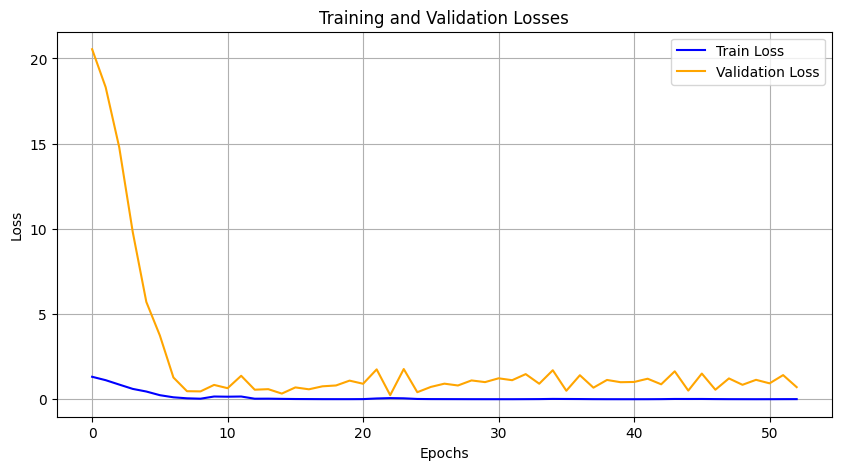

In [47]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [48]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.230890


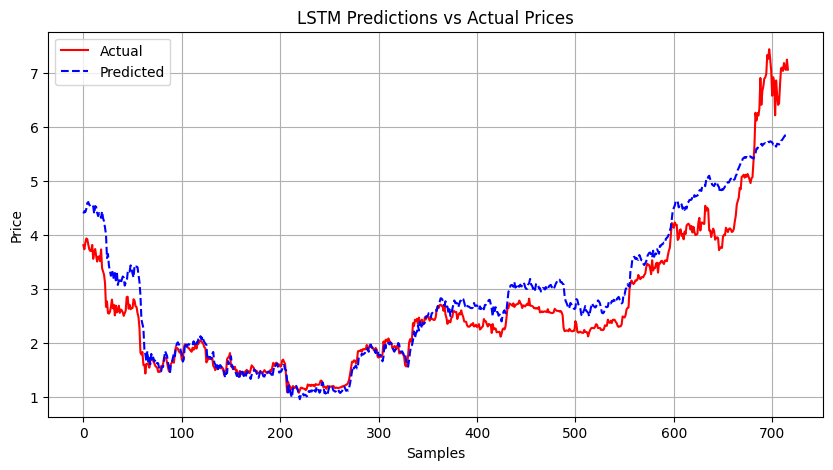

In [49]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()

In [16]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, conv_filters=96, conv_kernel=3, lstm_hidden=12, num_bilstm_layers=2, attn_heads=4, attn_dim=64, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden, num_layers=num_bilstm_layers, batch_first=True, bidirectional=True)
        # Use PyTorch MultiheadAttention: needs embedding dim. We'll map BiLSTM outputs to attn_dim
        self.proj = nn.Linear(2*lstm_hidden, attn_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=attn_heads, batch_first=True)
        self.out_fc = nn.Sequential(
            nn.Linear(attn_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: B,T,F
        x = x.permute(0,2,1)              # B,F,T
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.permute(0,2,1)              # B,T,conv_filters
        x = self.dropout(x)
        out, _ = self.bilstm(x)           # B,T,2*lstm_hidden
        proj = self.proj(out)             # B,T,attn_dim
        # MultiheadAttention expects (B, T, E) if batch_first=True
        attn_out, _ = self.attn(proj, proj, proj)  # self-attention
        # Pool (use last time step or mean)
        pooled = attn_out.mean(dim=1)     # B, attn_dim
        out = self.out_fc(pooled)         # B,1
        return out.squeeze(-1)


In [17]:
model2 = CNN_BiLSTM_Attention(input_dim=len(features))

In [18]:
model2 = model2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [19]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model2.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model2.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model2(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 68545
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Epoch [1/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 148.59it/s]


Epoch [2/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 127.55it/s]


Epoch [3/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.37it/s]


Epoch [4/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.13it/s]


Epoch [5/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 153.85it/s]


Epoch [6/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.90it/s]


Epoch [7/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.18it/s]


Epoch [8/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.50it/s]


Epoch [9/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.96it/s]


Epoch [10/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 134.05it/s]


Epoch [11/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 151.84it/s]


Epoch [12/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.95it/s]


Epoch [13/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.55it/s]


Epoch [14/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.32it/s]


Epoch [15/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.17it/s]


Epoch [16/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.97it/s]


Epoch [17/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.12it/s]


Epoch [18/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 160.51it/s]


Epoch [19/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.47it/s]


Epoch [20/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.98it/s]


Epoch [21/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.55it/s]


Epoch [22/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.27it/s]


Epoch [23/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.83it/s]


Epoch [24/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 157.12it/s]


Epoch [25/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.81it/s]


Epoch [26/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.23it/s]


Epoch [27/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.92it/s]


Epoch [28/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.05it/s]


Epoch [29/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.77it/s]


Epoch [30/500] - Train Loss: 1.222747, Val Loss: 18.042527
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.67it/s]

Epoch [31/500] - Train Loss: 1.222747, Val Loss: 18.042527
Early stopping triggered after epoch 31

Best validation loss: 18.042527
